In [1]:
#### ASSIGNMENT 03 - AIDI2000 ####
#### PART 03 - IMPROVED MLP ####

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load the dataset
data = pd.read_csv('dataset/synthetic_ecommerce_returns.csv')

In [3]:
# Configure pandas to display float numbers with 4 decimal places
pd.set_option('display.float_format', '{:.4f}'.format)

In [4]:
# Drop unnecessary/redundant columns
data = data.drop(columns=['Customer_ID'])

In [5]:
# Analyze categorical columns
categorical_cols = data.select_dtypes(include=['object','category']).columns
print("\nCategorical columns:", list(categorical_cols))


Categorical columns: ['Product_Category', 'Shipping_Method', 'Product_Size', 'Order_Date']


In [6]:
# Remove Order_Date and convert it to Days_Since_First_Order
if 'Order_Date' in categorical_cols:
    categorical_cols = categorical_cols.drop('Order_Date')

if 'Order_Date' in data.columns:
    data['Order_Date'] = pd.to_datetime(data['Order_Date'])
    data['Days_Since_First_Order'] = (data['Order_Date'] - data['Order_Date'].min()).dt.days
    data = data.drop('Order_Date', axis=1) 

print(data.head())

   Purchase_Amount Product_Category Shipping_Method  Delivery_Time_Days  \
0          46.9300             Home         Express                   4   
1         301.0100             Home        Standard                   5   
2         131.6700           Beauty       Overnight                   7   
3          91.2900             Home         Express                   6   
4          16.9600           Sports         Express                   4   

   Customer_Review_Score Product_Size  Discount_Applied  Return_Status  \
0                 4.6000        Small                 0              0   
1                 2.6000       Medium                 0              0   
2                 3.7000        Small                 1              0   
3                 3.8000       Medium                 1              0   
4                 5.0000        Large                 0              0   

   Days_Since_First_Order  
0                     188  
1                     207  
2                   

In [7]:
# Encode categorical variables
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    print(f"Encoded {col} with {len(le.classes_)} unique values")

Encoded Product_Category with 5 unique values
Encoded Shipping_Method with 4 unique values
Encoded Product_Size with 3 unique values


In [8]:
# Separate features and target
X = data.drop('Return_Status', axis=1)
y = data['Return_Status']

In [9]:
X.head(), y.head()

(   Purchase_Amount  Product_Category  Shipping_Method  Delivery_Time_Days  \
 0          46.9300                 3                0                   4   
 1         301.0100                 3                2                   5   
 2         131.6700                 0                1                   7   
 3          91.2900                 3                0                   6   
 4          16.9600                 4                0                   4   
 
    Customer_Review_Score  Product_Size  Discount_Applied  \
 0                 4.6000             2                 0   
 1                 2.6000             1                 0   
 2                 3.7000             2                 1   
 3                 3.8000             1                 1   
 4                 5.0000             0                 0   
 
    Days_Since_First_Order  
 0                     188  
 1                     207  
 2                     327  
 3                      25  
 4               

In [10]:
# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
X_scaled

array([[-0.52733963,  0.70265876, -1.3214991 , ...,  1.21885366,
        -0.67341545,  0.06885805],
       [ 2.04704985,  0.70265876,  0.46890748, ..., -0.01007723,
        -0.67341545,  0.2482349 ],
       [ 0.33126303, -1.41889547, -0.42629581, ...,  1.21885366,
         1.48496741,  1.38114129],
       ...,
       [-0.60029147, -1.41889547, -0.42629581, ...,  1.21885366,
        -0.67341545, -0.01610993],
       [ 0.71091658, -0.71171073, -0.42629581, ..., -1.23900813,
        -0.67341545,  0.06885805],
       [-0.08121885, -0.71171073, -0.42629581, ..., -1.23900813,
        -0.67341545, -1.70602863]])

In [12]:
# Split data into train, validation, and test sets (70%, 15%, 15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [13]:
# Build the baseline neural network model
def build_baseline_model():
    print("\nBuilding baseline neural network model...")
    model = Sequential([
        tf.keras.Input(shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [14]:
# Function to build and train the regularized model
def build_regularized_model():
    print("\nBuilding regularized neural network model...")
    model = Sequential([
        tf.keras.Input(shape=(X_train.shape[1],)),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)), # Add L2 regularization to the first layer
        Dropout(0.3), # Add dropout layer with 30% dropout rate
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [15]:
# Function to evaluate a model
def evaluate_model(model, X_test, y_test):
    # Make predictions on test set
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Print classification report
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.show()
    
    return report

In [16]:
# Train and evaluate the baseline model
baseline_model = build_baseline_model()
print("\nTraining the baseline neural network...")
baseline_history = baseline_model.fit(
    X_train, y_train,
    epochs=400,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)


Building baseline neural network model...

Training the baseline neural network...
Epoch 1/400
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7480 - loss: 0.5804 - val_accuracy: 0.8467 - val_loss: 0.4421
Epoch 2/400
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.8487 - loss: 0.4359 - val_accuracy: 0.8467 - val_loss: 0.4357
Epoch 3/400
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.8432 - loss: 0.4400 - val_accuracy: 0.8467 - val_loss: 0.4351
Epoch 4/400
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.8533 - loss: 0.4221 - val_accuracy: 0.8467 - val_loss: 0.4358
Epoch 5/400
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.8582 - loss: 0.4097 - val_accuracy: 0.8467 - val_loss: 0.4343
Epoch 6/400
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.8466 - loss: 0.4293 - val_accuracy: 0.8467 - val_loss: 0.4338
Epoch 7/400
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - accuracy: 0.8492 - loss: 0.4224 - val_accuracy: 0.8467 - val_loss: 0.4343
E

In [17]:
# Display baseline model summary
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,925 (7.52 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,284 (5.02 KB)

In [18]:
# Train and evaluate the regularized model with early stopping
regularized_model = build_regularized_model()
print("\nTraining the regularized neural network...")


Building regularized neural network model...

Training the regularized neural network...


In [19]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [20]:
# Train and evaluate the regularized model
regularized_history = regularized_model.fit(
    X_train, y_train,
    epochs=400,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/400
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6220 - loss: 0.7842 - val_accuracy: 0.8467 - val_loss: 0.5562
Epoch 2/400
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.8500 - loss: 0.5414 - val_accuracy: 0.8467 - val_loss: 0.5115
Epoch 3/400
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.8393 - loss: 0.5188 - val_accuracy: 0.8467 - val_loss: 0.4865
Epoch 4/400
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.8497 - loss: 0.4833 - val_accuracy: 0.8467 - val_loss: 0.4703
Epoch 5/400
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - accuracy: 0.8532 - loss: 0.4559 - val_accuracy: 0.8467 - val_loss: 0.4591
Epoch 6/400
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.8428 - loss: 0.4618 - val_accuracy: 0.8467 - val_loss: 0.4517
Epoch 7/400
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.8438 - loss: 0.4546 - val_accuracy: 0.8467 - val_loss: 0.4463
Epoch 8/400
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.8512 - loss: 0.4

In [21]:
# Display regularized model summary
regularized_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,925 (7.52 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,284 (5.02 KB)


--- Baseline Model Evaluation ---
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       636
           1       0.15      0.04      0.06       114

    accuracy                           0.82       750
   macro avg       0.50      0.50      0.48       750
weighted avg       0.74      0.82      0.77       750



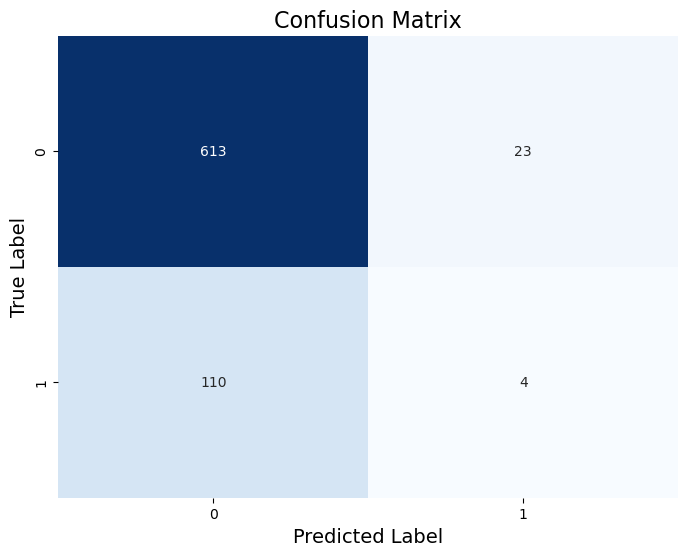

In [22]:
# Evaluate baseline models
print("\n--- Baseline Model Evaluation ---")
baseline_report = evaluate_model(baseline_model, X_test, y_test)


--- Regularized Model Evaluation ---
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       636
           1       0.00      0.00      0.00       114

    accuracy                           0.85       750
   macro avg       0.42      0.50      0.46       750
weighted avg       0.72      0.85      0.78       750



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pa

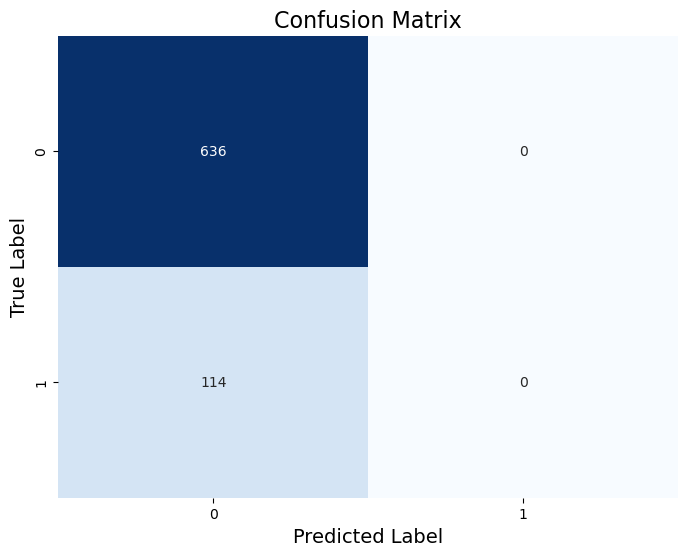

In [23]:
# Evaluate regularized models
print("\n--- Regularized Model Evaluation ---")
regularized_report = evaluate_model(regularized_model, X_test, y_test)

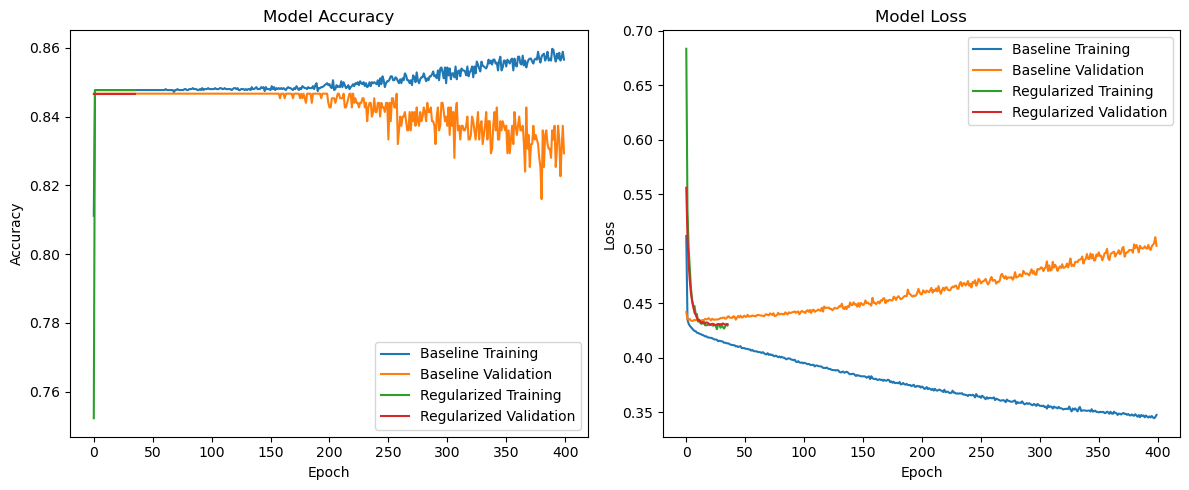

In [ ]:
# Plot training history for both models
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(baseline_history.history['accuracy'], label='Baseline Training')
plt.plot(baseline_history.history['val_accuracy'], label='Baseline Validation')
plt.plot(regularized_history.history['accuracy'], label='Regularized Training')
plt.plot(regularized_history.history['val_accuracy'], label='Regularized Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(baseline_history.history['loss'], label='Baseline Training')
plt.plot(baseline_history.history['val_loss'], label='Baseline Validation')
plt.plot(regularized_history.history['loss'], label='Regularized Training')
plt.plot(regularized_history.history['val_loss'], label='Regularized Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Create a comparison table of the results
def create_comparison_table(baseline_report, regularized_report):
    # Extract metrics from reports
    baseline_accuracy = baseline_report['accuracy']
    baseline_precision_0 = baseline_report['0']['precision']
    baseline_recall_0 = baseline_report['0']['recall']
    baseline_f1_0 = baseline_report['0']['f1-score']
    baseline_precision_1 = baseline_report['1']['precision'] if '1' in baseline_report else 0
    baseline_recall_1 = baseline_report['1']['recall'] if '1' in baseline_report else 0
    baseline_f1_1 = baseline_report['1']['f1-score'] if '1' in baseline_report else 0
    
    reg_accuracy = regularized_report['accuracy']
    reg_precision_0 = regularized_report['0']['precision']
    reg_recall_0 = regularized_report['0']['recall']
    reg_f1_0 = regularized_report['0']['f1-score']
    reg_precision_1 = regularized_report['1']['precision'] if '1' in regularized_report else 0
    reg_recall_1 = regularized_report['1']['recall'] if '1' in regularized_report else 0
    reg_f1_1 = regularized_report['1']['f1-score'] if '1' in regularized_report else 0
    
    # Create a DataFrame for the comparison table
    comparison_data = {
        'Metric': ['Accuracy', 'Class 0 Precision', 'Class 0 Recall', 'Class 0 F1-Score',
                  'Class 1 Precision', 'Class 1 Recall', 'Class 1 F1-Score'],
        'Baseline Model': [baseline_accuracy, baseline_precision_0, baseline_recall_0, baseline_f1_0,
                          baseline_precision_1, baseline_recall_1, baseline_f1_1],
        'Regularized Model': [reg_accuracy, reg_precision_0, reg_recall_0, reg_f1_0,
                             reg_precision_1, reg_recall_1, reg_f1_1],
        'Difference': [reg_accuracy - baseline_accuracy, 
                      reg_precision_0 - baseline_precision_0,
                      reg_recall_0 - baseline_recall_0,
                      reg_f1_0 - baseline_f1_0,
                      reg_precision_1 - baseline_precision_1,
                      reg_recall_1 - baseline_recall_1,
                      reg_f1_1 - baseline_f1_1]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df['Difference'] = comparison_df['Difference'].apply(lambda x: f"{x:.4f}")
    
    return comparison_df

In [26]:
# Display the comparison table
comparison_table = create_comparison_table(baseline_report, regularized_report)
print("\nModel Performance Comparison:")
print(comparison_table)


Model Performance Comparison:
              Metric  Baseline Model  Regularized Model Difference
0           Accuracy          0.8227             0.8480     0.0253
1  Class 0 Precision          0.8479             0.8480     0.0001
2     Class 0 Recall          0.9638             1.0000     0.0362
3   Class 0 F1-Score          0.9021             0.9177     0.0156
4  Class 1 Precision          0.1481             0.0000    -0.1481
5     Class 1 Recall          0.0351             0.0000    -0.0351
6   Class 1 F1-Score          0.0567             0.0000    -0.0567


In [27]:
# Explain the impact of each regularization technique
print("\n--- Impact of Regularization Techniques ---")
print("1. L2 Regularization:")
print("   - Adds a penalty to the loss function based on the squared magnitude of weights")
print("   - Helps prevent overfitting by discouraging large weights")
print("   - Impact: Tends to make the model more robust to noise in the training data")
print("\n2. Dropout Layers:")
print("   - Randomly sets a fraction of input units to 0 during training")
print("   - Forces the network to learn redundant representations")
print("   - Impact: Reduces co-adaptation of neurons and prevents overfitting")
print("\n3. Early Stopping:")
print("   - Monitors validation loss and stops training when it stops improving")
print("   - Prevents the model from overfitting by training for too many epochs")
print("   - Impact: Helps find the optimal point where the model generalizes best")
print("\nOverall Impact:")
print("These regularization techniques work together to improve the model's ability to generalize")
print("to unseen data, potentially improving performance on the test set, especially when the")
print("training data is limited or noisy.")


--- Impact of Regularization Techniques ---
1. L2 Regularization:
   - Adds a penalty to the loss function based on the squared magnitude of weights
   - Helps prevent overfitting by discouraging large weights
   - Impact: Tends to make the model more robust to noise in the training data

2. Dropout Layers:
   - Randomly sets a fraction of input units to 0 during training
   - Forces the network to learn redundant representations
   - Impact: Reduces co-adaptation of neurons and prevents overfitting

3. Early Stopping:
   - Monitors validation loss and stops training when it stops improving
   - Prevents the model from overfitting by training for too many epochs
   - Impact: Helps find the optimal point where the model generalizes best

Overall Impact:
These regularization techniques work together to improve the model's ability to generalize
to unseen data, potentially improving performance on the test set, especially when the
training data is limited or noisy.
